In [1]:
from bs4 import BeautifulSoup
import requests
import nltk
import math
nltk.download('stopwords')
import pandas as pd
import pickle
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import os
import networkx as nx
import networkx.algorithms.community as nx_community
from nltk.corpus import stopwords
import re
import string
from nltk.tokenize import word_tokenize
import networkx.algorithms.community as nx_comm
import netwulf
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from collections import Counter


[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1129)>


# Webscraping 
Retrieving all character names from wikisite: 
"https://en.wikipedia.org/wiki/List_of_Harry_Potter_characters"

In [35]:
# Characterlist from Wikipedia
url = 'https://en.wikipedia.org/wiki/List_of_Harry_Potter_characters'
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

# List for characters
character_list = []
content_div = soup.find('div', {'id': 'bodyContent'})
for heading in content_div.find_all('h3'):
    # find the <ul> tag immediately following this heading
    character_ul = heading.find_next_sibling('ul')
    for character_li in character_ul.find_all('li'):
        # extract the character name from the <a> tag within the <li>, if it exists
        character_a = character_li.find('a')
        if character_a:
            character_name = character_a.text
            character_list.append(character_name)

print(character_list)

['Hannah Abbott', 'Ludo Bagman', 'Bathilda Bagshot', 'Katie Bell', 'Cuthbert Binns', 'Phineas Nigellus Black', 'Sirius Black', 'Amelia Bones', 'Susan Bones', 'Terry Boot', 'Lavender Brown', 'Slytherin', 'Charity Burbage', 'Frank Bryce', 'Alecto Carrow', 'Amycus Carrow', 'Reginald Cattermole', 'Cho Chang', 'Percy Weasley', 'Crabbe', 'Vincent Crabbe', 'Colin Creevey', 'Dennis Creevey', 'Dirk Cresswell', 'Barty Crouch Sr', 'Barty Crouch Jr', 'John Dawlish', 'Fleur Delacour', 'Dedalus Diggle', 'Amos Diggory', 'Cedric Diggory', 'Elphias Doge', 'Antonin Dolohov', 'Aberforth Dumbledore', 'Albus Dumbledore', 'Ariana Dumbledore', 'Dudley Dursley', 'Marge Dursley', 'Petunia Dursley', 'Vernon Dursley', 'Marietta Edgecombe', 'Arabella Figg', 'Argus Filch', 'Justin Finch-Fletchley', 'Seamus Finnigan', 'Mundungus Fletcher', 'Filius Flitwick', 'Cornelius Fudge', 'Marvolo Gaunt', 'Merope Gaunt', 'Morfin Gaunt', 'Anthony Goldstein', 'Goyle', 'Gregory Goyle', 'Hermione Granger', 'Draco Malfoy', 'Eastern

In [36]:
# Ikke optimal løsning, men fikser alle fejlene, så vi kan smide en liste til API'en lidt hurtigt. 
replacements = {
    "Slytherin": "Millicent Bulstrode",
    "Percy Weasley": "Penelope Clearwater",
    "Draco Malfoy": "Astoria Greengrass",
    "Eastern European": "Gregorovitch",
    "Diagon Alley": "Madam Malkin",
    "Horace Slughorn": "Cormac McLaggen",
    "Vanishing Cabinet": "Graham Montague",
    "Harry Potter and the Cursed Child": "Delphi Riddle",
    "Merope Gaunt": "Tom Riddle Sr.",
    "Lord Voldemort": "Thomas Marvolo Riddle",
    "Bogrod": "Gringotts",
    "Gringotts": "Gornuk",
    "Black family": "Kreacher",
    "Death Eater" : "Travers",
    "Barty Crouch Sr": "Winky"}

for i in range(len(character_list)):
    if character_list[i] in replacements:
        character_list[i] = replacements[character_list[i]]

additions = ["Gabrielle Delacour", 
             "Kendra Dumbledore", 
             "Percival Dumbledore", 
             "Nicolas Flamel", 
             "Griselda Marchbanks", 
             "Eloise Midgen", 
             "Theodore Nott", 
             "Nott Sr", 
             "Albus Severus Potter", 
             "James Sirius Potter", 
             "Lily Luna Potter", 
             "Mary Riddle", 
             "Thomas Riddle", 
             "Demelza Robins", 
             "Salazar Slytherin", 
             "Romilda Vane", 
             "Hugo Weasley", 
             "Rose Weasley",
             "Millicent Bulstrode",
             "Blaise Zabini",
             "Sir Cadogan",
             "Scabior",
             "Trevor"]

print(character_list)

['Hannah Abbott', 'Ludo Bagman', 'Bathilda Bagshot', 'Katie Bell', 'Cuthbert Binns', 'Phineas Nigellus Black', 'Sirius Black', 'Amelia Bones', 'Susan Bones', 'Terry Boot', 'Lavender Brown', 'Millicent Bulstrode', 'Charity Burbage', 'Frank Bryce', 'Alecto Carrow', 'Amycus Carrow', 'Reginald Cattermole', 'Cho Chang', 'Penelope Clearwater', 'Crabbe', 'Vincent Crabbe', 'Colin Creevey', 'Dennis Creevey', 'Dirk Cresswell', 'Winky', 'Barty Crouch Jr', 'John Dawlish', 'Fleur Delacour', 'Dedalus Diggle', 'Amos Diggory', 'Cedric Diggory', 'Elphias Doge', 'Antonin Dolohov', 'Aberforth Dumbledore', 'Albus Dumbledore', 'Ariana Dumbledore', 'Dudley Dursley', 'Marge Dursley', 'Petunia Dursley', 'Vernon Dursley', 'Marietta Edgecombe', 'Arabella Figg', 'Argus Filch', 'Justin Finch-Fletchley', 'Seamus Finnigan', 'Mundungus Fletcher', 'Filius Flitwick', 'Cornelius Fudge', 'Marvolo Gaunt', 'Tom Riddle Sr.', 'Morfin Gaunt', 'Anthony Goldstein', 'Goyle', 'Gregory Goyle', 'Hermione Granger', 'Astoria Greengr

181

## Collecting data with Harry Potter API

In [2]:
# API for facts about Harry Potter characters
API = {"data":{"message":"Welcome to the Potter DB API!","api_routes":["/v1/books/:book_id/chapters","/v1/books/:book_id/chapters/:id","/v1/books","/v1/books/:id","/v1/characters","/v1/characters/:id","/v1/movies","/v1/movies/:id","/v1/potions","/v1/potions/:id","/v1/spells","/v1/spells/:id"]}}
API

{'data': {'message': 'Welcome to the Potter DB API!',
  'api_routes': ['/v1/books/:book_id/chapters',
   '/v1/books/:book_id/chapters/:id',
   '/v1/books',
   '/v1/books/:id',
   '/v1/characters',
   '/v1/characters/:id',
   '/v1/movies',
   '/v1/movies/:id',
   '/v1/potions',
   '/v1/potions/:id',
   '/v1/spells',
   '/v1/spells/:id']}}

In [75]:
# API link
BASE_URL = "https://api.potterdb.com/"
VERSION = "v1/"
RESOURCE = "characters"

my_url = BASE_URL + VERSION + RESOURCE
print(my_url)
all_data = {}
counter = 0
for i in range(50):

    url = my_url + f"?page[number={i+1}]&page[size=100]"
    r = requests.get(url)
    data = r.json()["data"]

    for i in data:
        all_data[counter] = {}
        name = (i['attributes']['name'])
        all_data[counter]['Name'] = i['attributes']['name']
        all_data[counter]['Blood status'] = i['attributes']['blood_status']
        all_data[counter]['House'] = i['attributes']['house']
        all_data[counter]['Species'] = i['attributes']['species']
        all_data[counter]['Death time'] = i['attributes']['died']
        all_data[counter]['Alias'] = i['attributes']['alias_names']
        all_data[counter]['Wiki'] = i['attributes']['wiki']
        all_data[counter]['Gender'] = i['attributes']['gender']
        counter +=1
    
df_data = pd.DataFrame.from_dict(all_data, orient='index')

https://api.potterdb.com/v1/characters


In [76]:
df_data

,name,Blood status,House,Species,Death time,Alias,Wiki,Gender
0,1992 Gryffindor vs Slytherin Quidditch match s...,None,None,None,None,None,https://harrypotter.fandom.com/wiki/1992_Gryff...,None
1,1996 Gryffindor Quidditch Keeper trials specta...,None,None,None,None,None,https://harrypotter.fandom.com/wiki/1996_Gryff...,None
2,19th-century Flying Instructor,None,None,Human,None,None,https://harrypotter.fandom.com/wiki/Unidentifi...,Female
3,19th-century Herbology professor,None,None,Human,None,None,https://harrypotter.fandom.com/wiki/Unidentifi...,Female
4,19th-century Potions professor,None,None,Human,None,None,https://harrypotter.fandom.com/wiki/Unidentifi...,Male
...,...,...,...,...,...,...,...,...
4061,Zoo director,Muggle,None,Human,None,None,https://harrypotter.fandom.com/wiki/Zoo_director,Male
4062,Zubeida Khan,None,Slytherin,Human,None,None,https://harrypotter.fandom.com/wiki/Zubeida_Khan,Female
4063,Zygmunt Budge,None,None,Human,None,"['Fungus-face' (by his mother), The Hermit of ...",https://harrypotter.fandom.com/wiki/Zygmunt_Budge,Male
4064,Zygmunt Budge's great-grandmother,None,None,Human,None,None,https://harrypotter.fandom.com/wiki/Zygmunt_Bu...,Female


In [78]:
# Filter data after having some information of Blood status, house, species, death time or alias
df_data[~((df_data["Blood status"].isnull())&(df_data["House"].isnull())&(df_data["Species"].isnull())&(df_data["Death time"].isnull())&(df_data["Alias"].isnull()))]

,name,Blood status,House,Species,Death time,Alias,Wiki,Gender
2,19th-century Flying Instructor,None,None,Human,None,None,https://harrypotter.fandom.com/wiki/Unidentifi...,Female
3,19th-century Herbology professor,None,None,Human,None,None,https://harrypotter.fandom.com/wiki/Unidentifi...,Female
4,19th-century Potions professor,None,None,Human,None,None,https://harrypotter.fandom.com/wiki/Unidentifi...,Male
5,2-Headed Baby,None,None,Human,None,None,https://harrypotter.fandom.com/wiki/2-Headed_Baby,Male (most likely)
6,8-year-old Muggle girl,Muggle,None,Human,None,None,https://harrypotter.fandom.com/wiki/Unidentifi...,Female
...,...,...,...,...,...,...,...,...
4061,Zoo director,Muggle,None,Human,None,None,https://harrypotter.fandom.com/wiki/Zoo_director,Male
4062,Zubeida Khan,None,Slytherin,Human,None,None,https://harrypotter.fandom.com/wiki/Zubeida_Khan,Female
4063,Zygmunt Budge,None,None,Human,None,"['Fungus-face' (by his mother), The Hermit of ...",https://harrypotter.fandom.com/wiki/Zygmunt_Budge,Male
4064,Zygmunt Budge's great-grandmother,None,None,Human,None,None,https://harrypotter.fandom.com/wiki/Zygmunt_Bu...,Female


## Webscrape text data and node links from wiki

In [114]:
# Function to webscrape Harry Potter wiki for text and links
def webscrapeWiki(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    content_div = soup.find('div', {'id': 'mw-content-text'})
    text = ""
    for p in content_div.find_all('p'):
        text += p.get_text() + " "

    links = []
    for a in content_div.find_all("a"):
        split = a['href'].split("/")
        if len(split)>1:
            if split[1]=="wiki":
                links.append(split[2])

    return text, links

df_data["Wiki text"], df_data["Character links"] = zip(*df_data["Wiki"].apply(webscrapeWiki))

In [123]:
df_data

,name,Blood status,House,Species,Death time,Alias,Wiki,Gender,Wiki text,Character links,Wiki name,Sum character links
0,1992 Gryffindor vs Slytherin Quidditch match s...,None,None,None,None,None,https://harrypotter.fandom.com/wiki/1992_Gryff...,None,The title of this article is conjectural. Alt...,"[Canon, Filius_Flitwick, Irma_Pince, Severus_S...",1992_Gryffindor_vs_Slytherin_Quidditch_match_s...,"{'Filius_Flitwick': 2, 'Irma_Pince': 3, 'Sever..."
1,1996 Gryffindor Quidditch Keeper trials specta...,None,None,None,None,None,https://harrypotter.fandom.com/wiki/1996_Gryff...,None,"In September 1996, a number of unidentified sp...","[Harry_Potter_and_the_Half-Blood_Prince, Septe...",1996_Gryffindor_Quidditch_Keeper_trials_specta...,"{'Harry_Potter': 1, 'Ronald_Weasley': 1, 'Corm..."
2,19th-century Flying Instructor,None,None,Human,None,None,https://harrypotter.fandom.com/wiki/Unidentifi...,Female,At least some content in this article is deriv...,"[Hogwarts_Legacy, 1872, Japan, Madam, Human, C...",Unidentified_19th-century_Flying_Instructor,{'Unidentified_19th-century_Hogwarts_student':...
3,19th-century Herbology professor,None,None,Human,None,None,https://harrypotter.fandom.com/wiki/Unidentifi...,Female,At least some content in this article is deriv...,"[Hogwarts_Legacy, 1873, London, England, Great...",Unidentified_19th-century_Herbology_professor,{'Unidentified_19th-century_Hogwarts_student':...
4,19th-century Potions professor,None,None,Human,None,None,https://harrypotter.fandom.com/wiki/Unidentifi...,Male,At least some content in this article is deriv...,"[Hogwarts_Legacy, 1850s, Great_Britain, Irelan...",Unidentified_19th-century_Potions_professor,{'Unidentified_19th-century_Hogwarts_student':...
...,...,...,...,...,...,...,...,...,...,...,...,...
4061,Zoo director,Muggle,None,Human,None,None,https://harrypotter.fandom.com/wiki/Zoo_director,Male,The title of this article is conjectural. Alt...,"[Canon, Non-magic_people, Great_Britain, Human...",Zoo_director,{'Petunia_Dursley': 1}
4062,Zubeida Khan,None,Slytherin,Human,None,None,https://harrypotter.fandom.com/wiki/Zubeida_Khan,Female,\n\nZubeida Khan\n\n\nBiographical information...,"[1_September, 1975, 31_August, 1982, Great_Bri...",Zubeida_Khan,{}
4063,Zygmunt Budge,None,None,Human,None,"['Fungus-face' (by his mother), The Hermit of ...",https://harrypotter.fandom.com/wiki/Zygmunt_Budge,Male,At least some content in this article is deriv...,"[Harry_Potter:_Magic_Awakened, 1490, 1491, 149...",Zygmunt_Budge,"{'Arsenius_Jigger': 1, 'Bilius_Finbok': 1, 'Bl..."
4064,Zygmunt Budge's great-grandmother,None,None,Human,None,None,https://harrypotter.fandom.com/wiki/Zygmunt_Bu...,Female,The title of this article is conjectural. Alt...,"[Canon, Human, Zygmunt_Budge%27s_mother, Zygmu...",Zygmunt_Budge's_great-grandmother,{'Zygmunt_Budge': 4}


In [120]:
def wikiName(wikiURL):
    return wikiURL.split("/")[-1]

def checkLinks(linkCounter, wikiNames):
    cleanLinks = linkCounter.copy()
    for link in linkCounter.keys():
        if link not in list(wikiNames):
            del cleanLinks[link]
    return cleanLinks

df_data["Wiki name"] = df_data["Wiki"].apply(wikiName)
df_data["Sum character links"] = df_data["Character links"].apply(Counter)
df_data["Sum character links"] = df_data["Sum character links"].apply(checkLinks,wikiNames=df_data["Wiki name"])


In [124]:
#Save dataframe
df_data.to_pickle("df_data")


In [129]:
# Load dataframe:
df_data_loaded = pd.read_pickle("df_data")

In [183]:
# Getting filtered data
def checkUnidentified(wikiName):
    check = "Unidentified"
    if len(wikiName)>len(check):
        if wikiName[:len(check)]==check:
            return True
    return False
    

filtered_data = df_data_loaded[~((df_data_loaded["Blood status"].isnull())&(df_data_loaded["House"].isnull())&(df_data_loaded["Species"].isnull())&(df_data_loaded["Death time"].isnull())&(df_data_loaded["Alias"].isnull()))]
filtered_data = filtered_data[~filtered_data["Wiki name"].apply(checkUnidentified)]
filtered_data["Sum character links"] = filtered_data["Sum character links"].apply(checkLinks,wikiNames=filtered_data["Wiki name"])

In [165]:
# Plotting distribution of species
species = filtered_data['Species']

# Finding all types of species
species_types = []
for i in species:
    if i not in species_types:
        species_types.append(i)

print(len(species_types)) # 192 different species

# Converting each species to an integer
dict = {}
for i in range(len(species_types)):
    dict[i] = species_types[i]
keys = list(dict.keys())
values = list(dict.values())

# Making list of species integers
species_int = []
for i in species:
    for j in range(len(values)):
        if i == values[j]:
            species_int.append(keys[j])

192


Text(0, 0.5, 'Count')

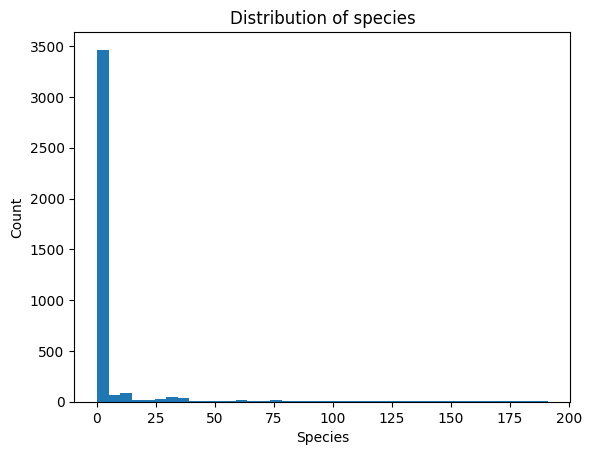

In [166]:
# Plotting distribution
bins = np.linspace(min(species_int), max(species_int), 40)
hist, edges = np.histogram(species_int, bins=bins)
x = (edges[1:]+edges[:-1])/2
width = bins[1]-bins[0]
fig, ax = plt.subplots()
ax.bar(x, hist, width)
ax.set_title('Distribution of species')
ax.set_xlabel('Species')
ax.set_ylabel('Count')
# Very heavy tailed therefore log transforming

Text(0.5, 1.0, 'Distribution of species in log space')

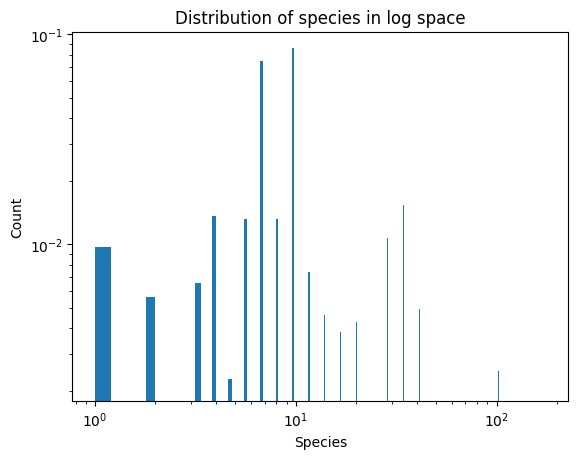

In [167]:
# Plotting species distribution in log space
bins = np.logspace(0, np.log10(192), 30)
hist, edges = np.histogram(species_int, bins=bins, density=True)
x = (edges[1:]+edges[:-1])/2
#xx, yy = zip(*[(i,j) for (i,j) in zip(x, hist) if j>0])
width = bins[1]-bins[0]
fig, ax = plt.subplots()
ax.bar(x, hist, width)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Species')
ax.set_ylabel('Count')
ax.set_title('Distribution of species in log space')

In [168]:
filtered_data

,name,Blood status,House,Species,Death time,Alias,Wiki,Gender,Wiki text,Character links,Wiki name,Sum character links
2,19th-century Flying Instructor,None,None,Human,None,None,https://harrypotter.fandom.com/wiki/Unidentifi...,Female,At least some content in this article is deriv...,"[Hogwarts_Legacy, 1872, Japan, Madam, Human, C...",Unidentified_19th-century_Flying_Instructor,{'Unidentified_19th-century_Hogwarts_student':...
3,19th-century Herbology professor,None,None,Human,None,None,https://harrypotter.fandom.com/wiki/Unidentifi...,Female,At least some content in this article is deriv...,"[Hogwarts_Legacy, 1873, London, England, Great...",Unidentified_19th-century_Herbology_professor,{'Unidentified_19th-century_Hogwarts_student':...
4,19th-century Potions professor,None,None,Human,None,None,https://harrypotter.fandom.com/wiki/Unidentifi...,Male,At least some content in this article is deriv...,"[Hogwarts_Legacy, 1850s, Great_Britain, Irelan...",Unidentified_19th-century_Potions_professor,{'Unidentified_19th-century_Hogwarts_student':...
5,2-Headed Baby,None,None,Human,None,None,https://harrypotter.fandom.com/wiki/2-Headed_Baby,Male (most likely),\n\n\n\n\n\n\n\n2-Headed Baby\n\n\nBiographica...,"[1927, Human, Circus_Arcanus, Template:Individ...",2-Headed_Baby,{}
6,8-year-old Muggle girl,Muggle,None,Human,None,None,https://harrypotter.fandom.com/wiki/Unidentifi...,Female,The title of this article is conjectural. Alt...,"[Canon, 1983, Non-magic_people, Human, Templat...",Unidentified_8-year-old_Muggle_girl,{}
...,...,...,...,...,...,...,...,...,...,...,...,...
4061,Zoo director,Muggle,None,Human,None,None,https://harrypotter.fandom.com/wiki/Zoo_director,Male,The title of this article is conjectural. Alt...,"[Canon, Non-magic_people, Great_Britain, Human...",Zoo_director,{'Petunia_Dursley': 1}
4062,Zubeida Khan,None,Slytherin,Human,None,None,https://harrypotter.fandom.com/wiki/Zubeida_Khan,Female,\n\nZubeida Khan\n\n\nBiographical information...,"[1_September, 1975, 31_August, 1982, Great_Bri...",Zubeida_Khan,{}
4063,Zygmunt Budge,None,None,Human,None,"['Fungus-face' (by his mother), The Hermit of ...",https://harrypotter.fandom.com/wiki/Zygmunt_Budge,Male,At least some content in this article is deriv...,"[Harry_Potter:_Magic_Awakened, 1490, 1491, 149...",Zygmunt_Budge,"{'Arsenius_Jigger': 1, 'Bilius_Finbok': 1, 'Bl..."
4064,Zygmunt Budge's great-grandmother,None,None,Human,None,None,https://harrypotter.fandom.com/wiki/Zygmunt_Bu...,Female,The title of this article is conjectural. Alt...,"[Canon, Human, Zygmunt_Budge%27s_mother, Zygmu...",Zygmunt_Budge's_great-grandmother,{'Zygmunt_Budge': 4}


In [169]:
# making edgelist
wiki_names = list(filtered_data['Wiki name'])
character_links = filtered_data['Sum character links']
edgelist = {}

'''
for i in range(len(filtered_data)):
        edgelist[wiki_names[i]] = character_links[i]
'''

# Initializing graph
G = nx.MultiDiGraph()
G.add_nodes_from(wiki_names)
print(G)

MultiDiGraph with 3973 nodes and 0 edges


In [170]:
edges = []
for j in filtered_data.index:
    name = filtered_data['Wiki name'][j]
    links = filtered_data['Sum character links'][j]
    for key, val in links.items():
        edges.append(((name, key, val)))

    #for k in keys:
     #   for w in values:
      #      edges.append(((name, k, w)))

In [171]:
G.add_weighted_edges_from(edges)
print(G)

MultiDiGraph with 3973 nodes and 128450 edges


In [180]:
remove = [node for node,degree in G.degree() if degree == 0]
G.remove_nodes_from(remove)
print(f"{len(remove)} nodes with degree 0 were removed.")
print(G)

0 nodes with degree 0 were removed.
MultiDiGraph with 3380 nodes and 128450 edges


In [176]:
houses = list(filtered_data['House'])
dict_houses = {}
for i in range(len(houses)):
    dict_houses[i] = houses[i]
    
print(dict_houses)
#G.node_dict_factory(G, dict_houses, 'group')

{0: None, 1: None, 2: None, 3: None, 4: None, 5: 'Gryffindor', 6: None, 7: None, 8: None, 9: 'Gryffindor', 10: 'Slytherin', 11: None, 12: None, 13: None, 14: None, 15: 'Hufflepuff', 16: None, 17: None, 18: 'Slytherin', 19: None, 20: 'Slytherin', 21: None, 22: None, 23: None, 24: None, 25: None, 26: None, 27: 'Gryffindor', 28: None, 29: 'Slytherin', 30: None, 31: 'Slytherin', 32: 'Hufflepuff', 33: None, 34: None, 35: None, 36: 'Hufflepuff', 37: None, 38: None, 39: None, 40: None, 41: 'Slytherin', 42: None, 43: None, 44: None, 45: 'Gryffindor', 46: None, 47: None, 48: 'Hufflepuff', 49: None, 50: 'Ravenclaw', 51: 'Ravenclaw', 52: None, 53: None, 54: None, 55: None, 56: None, 57: 'Unknown', 58: None, 59: None, 60: 'Hufflepuff', 61: None, 62: None, 63: None, 64: None, 65: None, 66: None, 67: None, 68: None, 69: None, 70: None, 71: None, 72: None, 73: None, 74: None, 75: None, 76: None, 77: 'Gryffindor', 78: None, 79: None, 80: 'Slytherin', 81: None, 82: None, 83: 'Slytherin', 84: None, 85: 

In [177]:
print(G.degree)

[('Unidentified_19th-century_Flying_Instructor', 134), ('Unidentified_19th-century_Herbology_professor', 145), ('Unidentified_19th-century_Potions_professor', 213), ('Aberforth_Dumbledore', 257), ('Abernathy', 129), ('Abigail_Nicola', 306), ('Abigail_R._Cankus', 1), ('Able_Fleming', 90), ('Able_Spudmore', 4), ('Abraham', 3), ('Abraham_Grimblehawk', 4), ('Abraham_Peasegood', 2), ('Abraham_Potter', 102), ('Abraham_Ronen', 307), ('Abraxan_at_the_Magical_Creatures_Reserve', 44), ('Abraxas_Malfoy', 27), ('Achilles_Tolliver', 92), ('Acolyte_thug', 1), ('Actor_who_played_Crapaud', 6), ('Actor_who_played_Grenouille', 6), ('Adalbert_Waffling', 250), ('Adam_Pickering', 1), ('Addison_Fawley', 15), ('Adrian', 52), ('Adrian_Pucey', 309), ('Adrian_Tutley', 35), ('African_prince', 3), ('Agatha_Timms', 2), ('Aged_witch', 2), ('Agilbert_Fontaine', 13), ('Agnes', 2), ('Agnes_Monkleigh', 2), ('Agnes_Nutt', 56), ("Agnes's_son", 1), ('Aidan_Lynch', 317), ('Aisha', 3), ("Aisha's_mother", 2), ('Alain_Lacroix

In [178]:
# Finding communities
import networkx.algorithms.community as nx_community
communities = nx_community.louvain_communities(G)

no_comm = len(communities)
print('The number of communities is ' + str(no_comm))

The number of communities is 252


In [179]:
netwulf.interactive.visualize(G)

(None, None)

## Code snippet for webscraping of actual wikipedia

In [25]:
for name in character_list:
    name_url = name.replace(' ', '_')
    url = f"https://en.wikipedia.org/wiki/{name_url}"

    # Send request 
    response = requests.get(url)

    # Exists? 
    if response.status_code == 200:
        print(f"{name}: Wikipedia page exists.")
    else:
        print(f"{name}: Wikipedia page does not exist.")